# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project Description: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to
    **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0a: Import Libraries

In [1]:
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from imgaug import augmenters as iaa
%matplotlib inline

## Step 0b: Load The Data

In [2]:
training_file = '../Data/traffic-signs-data/train.p'
validation_file= '../Data/traffic-signs-data/valid.p'
testing_file = '../Data/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

See the basic data summary below. 

### Basic Summary of the Data Set

In [3]:
#Number of training examples
n_train = len(X_train)

#Number of validation examples
n_validation = len(X_valid)

#Number of testing examples.
n_test = len(X_test)

#What's the shape of an traffic sign image?
image_shape = X_train[0].shape

#How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))


print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

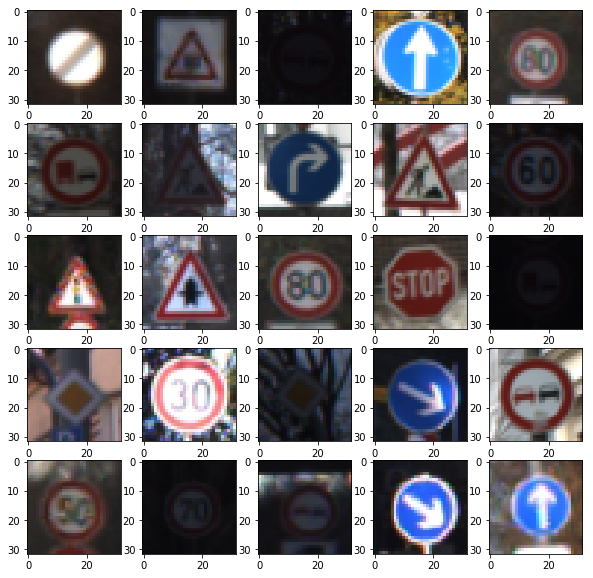

In [4]:
X_train, y_train = shuffle(X_train, y_train)

sample = random.sample(range(0, n_train), 25)
fig = plt.figure(figsize=(10,10))
for i in range(25):
    a=fig.add_subplot(5,5,i+1)
    plt.imshow(X_train[sample[i]])

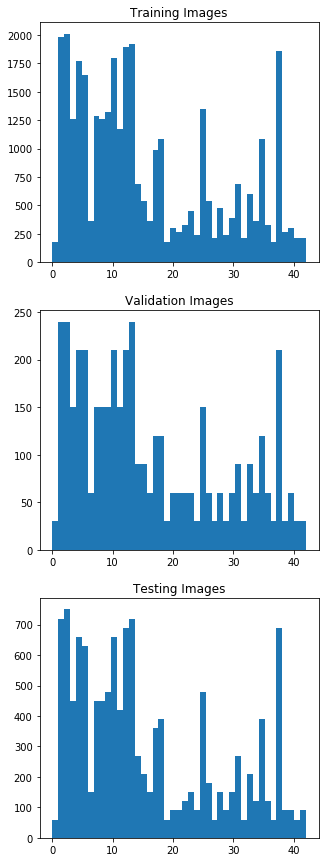

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(5,15))

axes[0].hist(y_train, bins=n_classes)
axes[1].hist(y_valid, bins=n_classes)
axes[2].hist(y_test, bins=n_classes)
axes[0].set_title('Training Images')
axes[1].set_title('Validation Images')
axes[2].set_title('Testing Images')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Designed and implemented a deep learning model that learns to recognize traffic signs. Trained and tested the model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).
Following steps are included to optimzed the model accuracy:

- Balanced the distribution of number of examples per label.
- Performed mage Augmentation.
- Converted RBG images to grayscale, then performed normalization on grayscale images.
- 50% drop out rate was used

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) is used for benchmarking.

Four other Neural network architecture were trained. 


### Data Augmentation

In [6]:
import random
unique, counts = np.unique(y_train, return_counts=True)
prob = min(counts)/counts
rand_array = np.random.rand(n_train)
keep = np.zeros((n_train), dtype=np.uint8)
for i in range(n_train):
    keep[i] = rand_array[i] < prob[y_train[i]]
    
balanced_X_train = np.zeros((sum(keep), 32, 32, 3), dtype=np.uint8)
balanced_y_train = np.zeros(sum(keep), dtype=np.uint8)
count = 0
for i in range(n_train):
    if keep[i]:
        balanced_X_train[count] = X_train[i]
        balanced_y_train[count] = y_train[i]
        count += 1

In [7]:
def image_aug(image_set, label_set):
    count = 0
    for image, label in zip(image_set, label_set):   

        shear = iaa.Affine(shear=(-5,5)) 
        for i in range(5):
            image_aug_set[count] = shear.augment_image(np.copy(image))
            np.append(label_set, label)
            label_aug_set[count] = label
            count += 1
        
        translater = iaa.Affine(translate_percent={"x": (-0.07, 0.07), "y": (-0.07, 0.07)})
        for i in range(5):
            image_aug_set[count] = translater.augment_image(np.copy(image))
            np.append(label_set, label)
            label_aug_set[count] = label
            count += 1
            
        scaler = iaa.Affine(scale={"y": (0.9, 1.1)}) 
        for i in range(5):
            image_aug_set[count] = scaler.augment_image(np.copy(image))
            np.append(label_set, label)
            label_aug_set[count] = label
            count += 1
        
        rotate = iaa.Affine(rotate=(-15, 15)) 
        for i in range(5):
            image_aug_set[count] = rotate.augment_image(np.copy(image))
            np.append(label_set, label)
            label_aug_set[count] = label
            count += 1
    
    return image_aug_set, label_aug_set

In [8]:
image_aug_set = np.zeros((sum(keep)*20, 32, 32, 3), dtype=np.uint8)
label_aug_set = np.zeros(sum(keep)*20, dtype=np.uint8)

new_X_train, new_y_train = image_aug(balanced_X_train, balanced_y_train)

X_train = np.append(balanced_X_train, new_X_train, axis=0)
y_train = np.append(balanced_y_train, new_y_train, axis=0)
X_train = X_train.astype(np.uint8)

In [9]:
new_train = {}
new_train['features'] = X_train
new_train['labels'] = y_train

new_training_file = '../Data/traffic-signs-data/train_more_data.p'

with open(new_training_file, mode='wb') as f:
    pickle.dump(new_train, f)

In [10]:
new_training_file = '../Data/traffic-signs-data/train_more_data.p'

with open(new_training_file, mode='rb') as f:
    train = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']

### Pre-process the Data Set

**Step 1: Normalization**

In [11]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
 
X_train_gray = rgb2gray(X_train)
X_valid_gray = rgb2gray(X_valid)
X_test_gray = rgb2gray(X_test)


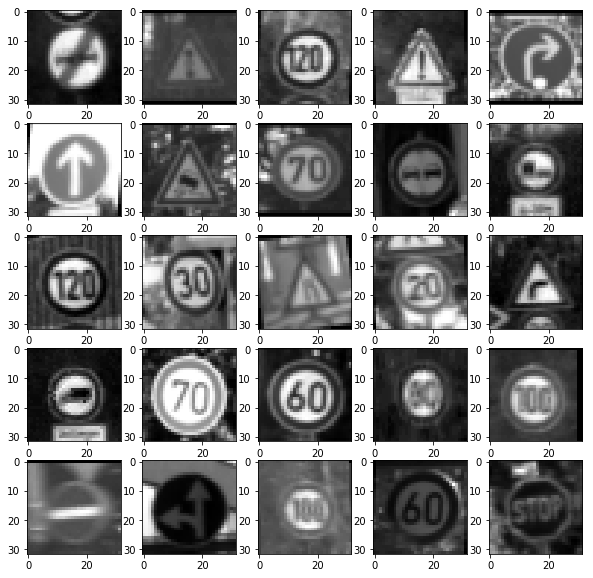

In [12]:
fig = plt.figure(figsize=(10,10))
for i in range(25):
    a=fig.add_subplot(5,5,i+1)
    plt.imshow(X_train_gray[sample[i]], cmap = plt.get_cmap('gray'))
plt.show()

In [14]:
def normalization(image):
    return (image - np.min(image))\
            /(np.max(image) - np.min(image))\
            *255
        
X_train_norm = np.zeros(X_train_gray.shape)
X_valid_norm = np.zeros(X_valid_gray.shape)
X_test_norm = np.zeros(X_test_gray.shape)
    
for i in range(n_train):
    X_train_norm[i] = normalization(X_train_gray[i])
    
for i in range(n_validation):
    X_valid_norm[i] = normalization(X_valid_gray[i])

for i in range(n_test):
    X_test_norm[i] = normalization(X_test_gray[i])

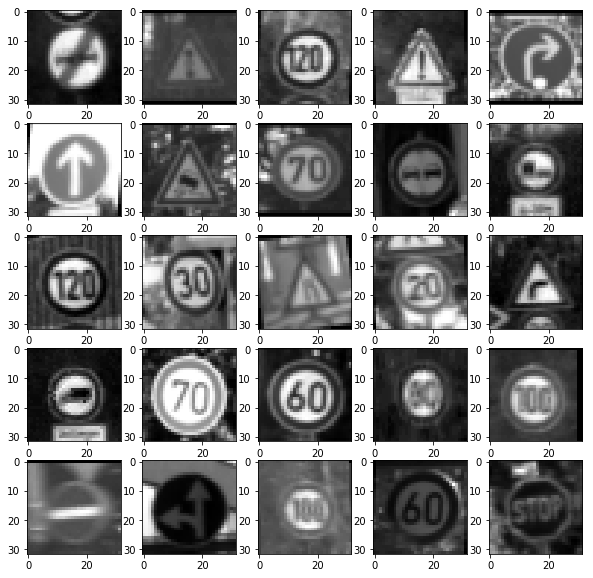

In [15]:
fig = plt.figure(figsize=(10,10))
for i in range(25):
    a=fig.add_subplot(5,5,i+1)
    plt.imshow(X_train_norm[sample[i]], cmap = plt.get_cmap('gray'))
plt.show()

In [16]:
X_train_ = X_train_norm.reshape(X_train_norm.shape[0],
                                     X_train_norm.shape[1],
                                     X_train_norm.shape[2], 1)
X_valid_ = X_valid_norm.reshape(X_valid_norm.shape[0],
                                     X_valid_norm.shape[1],
                                    X_valid_norm.shape[2], 1)
X_test_ = X_test_norm.reshape(X_test_norm.shape[0],
                                     X_test_norm.shape[1],
                                    X_test_norm.shape[2], 1)

In [18]:
print(X_train_.shape, X_valid_.shape, X_test_.shape)

(164913, 32, 32, 1) (4410, 32, 32, 1) (12630, 32, 32, 1)


### Model Architecture

In [ ]:
EPOCHS = 15
BATCH_SIZE = 128

In [ ]:
def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)

    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

In [ ]:
def AlexNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    
    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    
    #CONV3. INPUT = 5x5x16. Output = 5x5x32
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_b

    # SOLUTION: Activation.
    conv3 = tf.nn.relu(conv3)
    
         
    #CONV4. INPUT = 5x5x32. Output = 5x5x32
    conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(64))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='SAME') + conv4_b

    # SOLUTION: Activation.
    conv4 = tf.nn.relu(conv4) 
    
    
    #CONV5. INPUT = 5x5x32. Output = 5x5x16
    conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 32), mean = mu, stddev = sigma))
    conv5_b = tf.Variable(tf.zeros(32))
    conv5   = tf.nn.conv2d(conv4, conv5_W, strides=[1, 1, 1, 1], padding='SAME') + conv5_b

    # SOLUTION: Activation.
    conv5 = tf.nn.relu(conv5) 
    
    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv5)

    
    # SOLUTION: Layer 4: Fully Connected. Input = 400. Output = 120.
    fc1_W  = tf.Variable(tf.truncated_normal(shape=(800,200), mean = mu, stddev = sigma))
    fc1_b  = tf.Variable(tf.zeros(200))
    fc1    = tf.matmul(fc0, fc1_W) + fc1_b

    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    
    # SOLUTION: Layer 4: Fully Connected. Input = 512. Output = 256.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(200, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits


In [ ]:
def VGGNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv11_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 6), mean = mu, stddev = sigma))
    conv11_b = tf.Variable(tf.zeros(6))
    conv11   = tf.nn.conv2d(x, conv11_W, strides=[1, 1, 1, 1], padding='SAME') + conv11_b

    # SOLUTION: Activation.
    conv11 = tf.nn.relu(conv11)
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv12_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 6, 6), mean = mu, stddev = sigma))
    conv12_b = tf.Variable(tf.zeros(6))
    conv12   = tf.nn.conv2d(conv11, conv12_W, strides=[1, 1, 1, 1], padding='SAME') + conv12_b

    # SOLUTION: Activation.
    conv12 = tf.nn.relu(conv12)
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv13_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 6, 6), mean = mu, stddev = sigma))
    conv13_b = tf.Variable(tf.zeros(6))
    conv13   = tf.nn.conv2d(conv12, conv13_W, strides=[1, 1, 1, 1], padding='SAME') + conv13_b

    # SOLUTION: Activation.
    conv13 = tf.nn.relu(conv13)
    
    # SOLUTION: Pooling.  Output = 16x16x6.
    conv1 = tf.nn.max_pool(conv13, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    
    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv21_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 6, 16), mean = mu, stddev = sigma))
    conv21_b = tf.Variable(tf.zeros(16))
    conv21   = tf.nn.conv2d(conv1, conv21_W, strides=[1, 1, 1, 1], padding='SAME') + conv21_b

    # SOLUTION: Activation.
    conv21 = tf.nn.relu(conv21)
    
    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv22_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 16), mean = mu, stddev = sigma))
    conv22_b = tf.Variable(tf.zeros(16))
    conv22   = tf.nn.conv2d(conv21, conv22_W, strides=[1, 1, 1, 1], padding='SAME') + conv22_b

    # SOLUTION: Activation.
    conv22 = tf.nn.relu(conv22)
    
    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv23_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 16), mean = mu, stddev = sigma))
    conv23_b = tf.Variable(tf.zeros(16))
    conv23   = tf.nn.conv2d(conv22, conv23_W, strides=[1, 1, 1, 1], padding='SAME') + conv23_b

    # SOLUTION: Activation.
    conv23 = tf.nn.relu(conv23)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 8x8x16.
    conv2 = tf.nn.max_pool(conv23, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    
    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)

    
    # SOLUTION: Layer 4: Fully Connected. Input = 400. Output = 120.
    fc1_W  = tf.Variable(tf.truncated_normal(shape=(1024,256), mean = mu, stddev = sigma))
    fc1_b  = tf.Variable(tf.zeros(256))
    fc1    = tf.matmul(fc0, fc1_W) + fc1_b

    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    
    # SOLUTION: Layer 4: Fully Connected. Input = 512. Output = 256.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(256, 64), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(64))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(64, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits


In [ ]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

keep_prob = tf.placeholder(tf.float32) # probability to keep units

In [ ]:
rate = 0.001
drop_out = 0.5

#logits = LeNet(x)
#logits = AlexNet(x)
logits = VGGNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [ ]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, drop_out):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: drop_out})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_, y_train = shuffle(X_train_, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: drop_out})
        train_accuracy = evaluate(X_train_,y_train, 1)
        validation_accuracy = evaluate(X_valid_, y_valid, 1)
        print("EPOCH {} ...".format(i+1))
        print("train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, '../CarND-TSCP-Models/VGGNet_1')
    print("Model saved")

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")